In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from tqdm import tqdm
from lmfit import minimize, Parameters, report_fit

# objective function calculates residuals of fits
def objective(params, oligo_list, ratio, chamber):
    resid = np.zeros(ratio.shape)
    # make residual per data set
    for i in oligo_list:
        resid[i-1, :] = ratio[i-1, :] - isotherm_dataset(params, i, chamber[i-1,:])
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

# function to calculate for fit
def isotherm(x,ymax,Kd):
    y = [ymax*DNA/(DNA+Kd) for DNA in x]
    return y

def isotherm_dataset(params, i, x):
    """calc isotherm from params for data set i
    using simple, hardwired naming convention"""
    Kd = params['Kd_%i' % i].value
    ymax = params['ymax'].value
    return isotherm(x, ymax, Kd)

In [2]:
#calibration curves parameters
slope = 15.37
intercept = 0
calibration_exposure = 300 #ms
exposure = 200 #ms

oligonames = pd.read_csv('library1_names_sequences.csv', dtype={'Oligo_Identity': int,'Title': str})

In [3]:
# Pull in prewash Cy5 data
prewash_Cy5 = pd.read_csv('sample_prewashcy5.csv')
prewash_Cy5 = prewash_Cy5.add_suffix('_prewashCy5')
prewash_Cy5.rename(columns={'x_prewashCy5': 'x','y_prewashCy5': 'y','id_prewashCy5': 'id'}, inplace=True)
prewash_Cy5['Chamber_Index'] = prewash_Cy5['x'].map(str)+','+prewash_Cy5['y'].map(str)

#pull in postwash GFP data 
postwash_GFP = pd.read_csv('sample_postwashgfp.csv')
postwash_GFP = postwash_GFP.add_suffix('_postwashGFP')
postwash_GFP.rename(columns={'x_postwashGFP': 'x','y_postwashGFP': 'y','id_postwashGFP': 'id'}, inplace=True)
postwash_GFP['Chamber_Index'] = postwash_GFP['x'].map(str)+','+postwash_GFP['y'].map(str)


#pull in postwash Cy5 data 
postwash_Cy5 = pd.read_csv('sample_postwashcy5.csv')
postwash_Cy5 = postwash_Cy5.add_suffix('_postwashCy5')
postwash_Cy5.rename(columns={'step_postwashCy5':'step','x_postwashCy5': 'x','y_postwashCy5': 'y','id_postwashCy5': 'id'}, inplace=True)
postwash_Cy5['Chamber_Index'] = postwash_Cy5['x'].map(str)+','+postwash_Cy5['y'].map(str)


#now perform merging: common columns are x, y, id, and step
postwash_df = pd.merge(postwash_GFP,postwash_Cy5, how='left',on=['id','x','y','Chamber_Index'])
rawdata_df = pd.merge(postwash_df, prewash_Cy5, how='left', on=['id','x','y','Chamber_Index'])

#drop all columns with '0_0' id
rawdata_df = rawdata_df[rawdata_df['id']!='0_0']

#calculate ratio
rawdata_df['R_bSub'] = rawdata_df['summed_button_BGsub_postwashCy5']/rawdata_df['summed_button_BGsub_postwashGFP']

#split the id into two columns one is the oligo identity and the other is the oligo concentration...
rawdata_df['Oligo_Identity'] = rawdata_df['id'].apply(lambda x: int(x.split('_')[0]))
rawdata_df['Oligo_Concentration'] = rawdata_df['id'].apply(lambda x: (int(x.split('_')[1])+3)%8+1)

#map intensity to DNA concentration
rawdata_df['DNA_Conc_Std'] = (rawdata_df['median_chamber_prewashCy5']*calibration_exposure)/(slope*exposure)

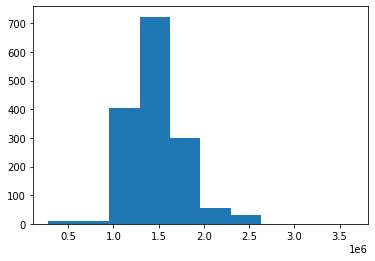

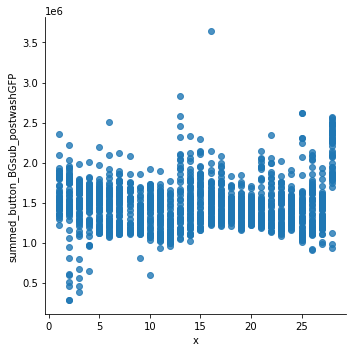

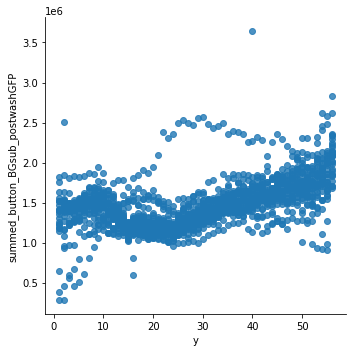

In [4]:
#okay, so now we want to visualize the protein distribution overall in the device to assist with culling on the dataset

plt.hist(rawdata_df['summed_button_BGsub_postwashGFP'])

sns.lmplot(x='x',y='summed_button_BGsub_postwashGFP',data=rawdata_df,fit_reg=False)

sns.lmplot(x='y',y='summed_button_BGsub_postwashGFP',data=rawdata_df,fit_reg=False)

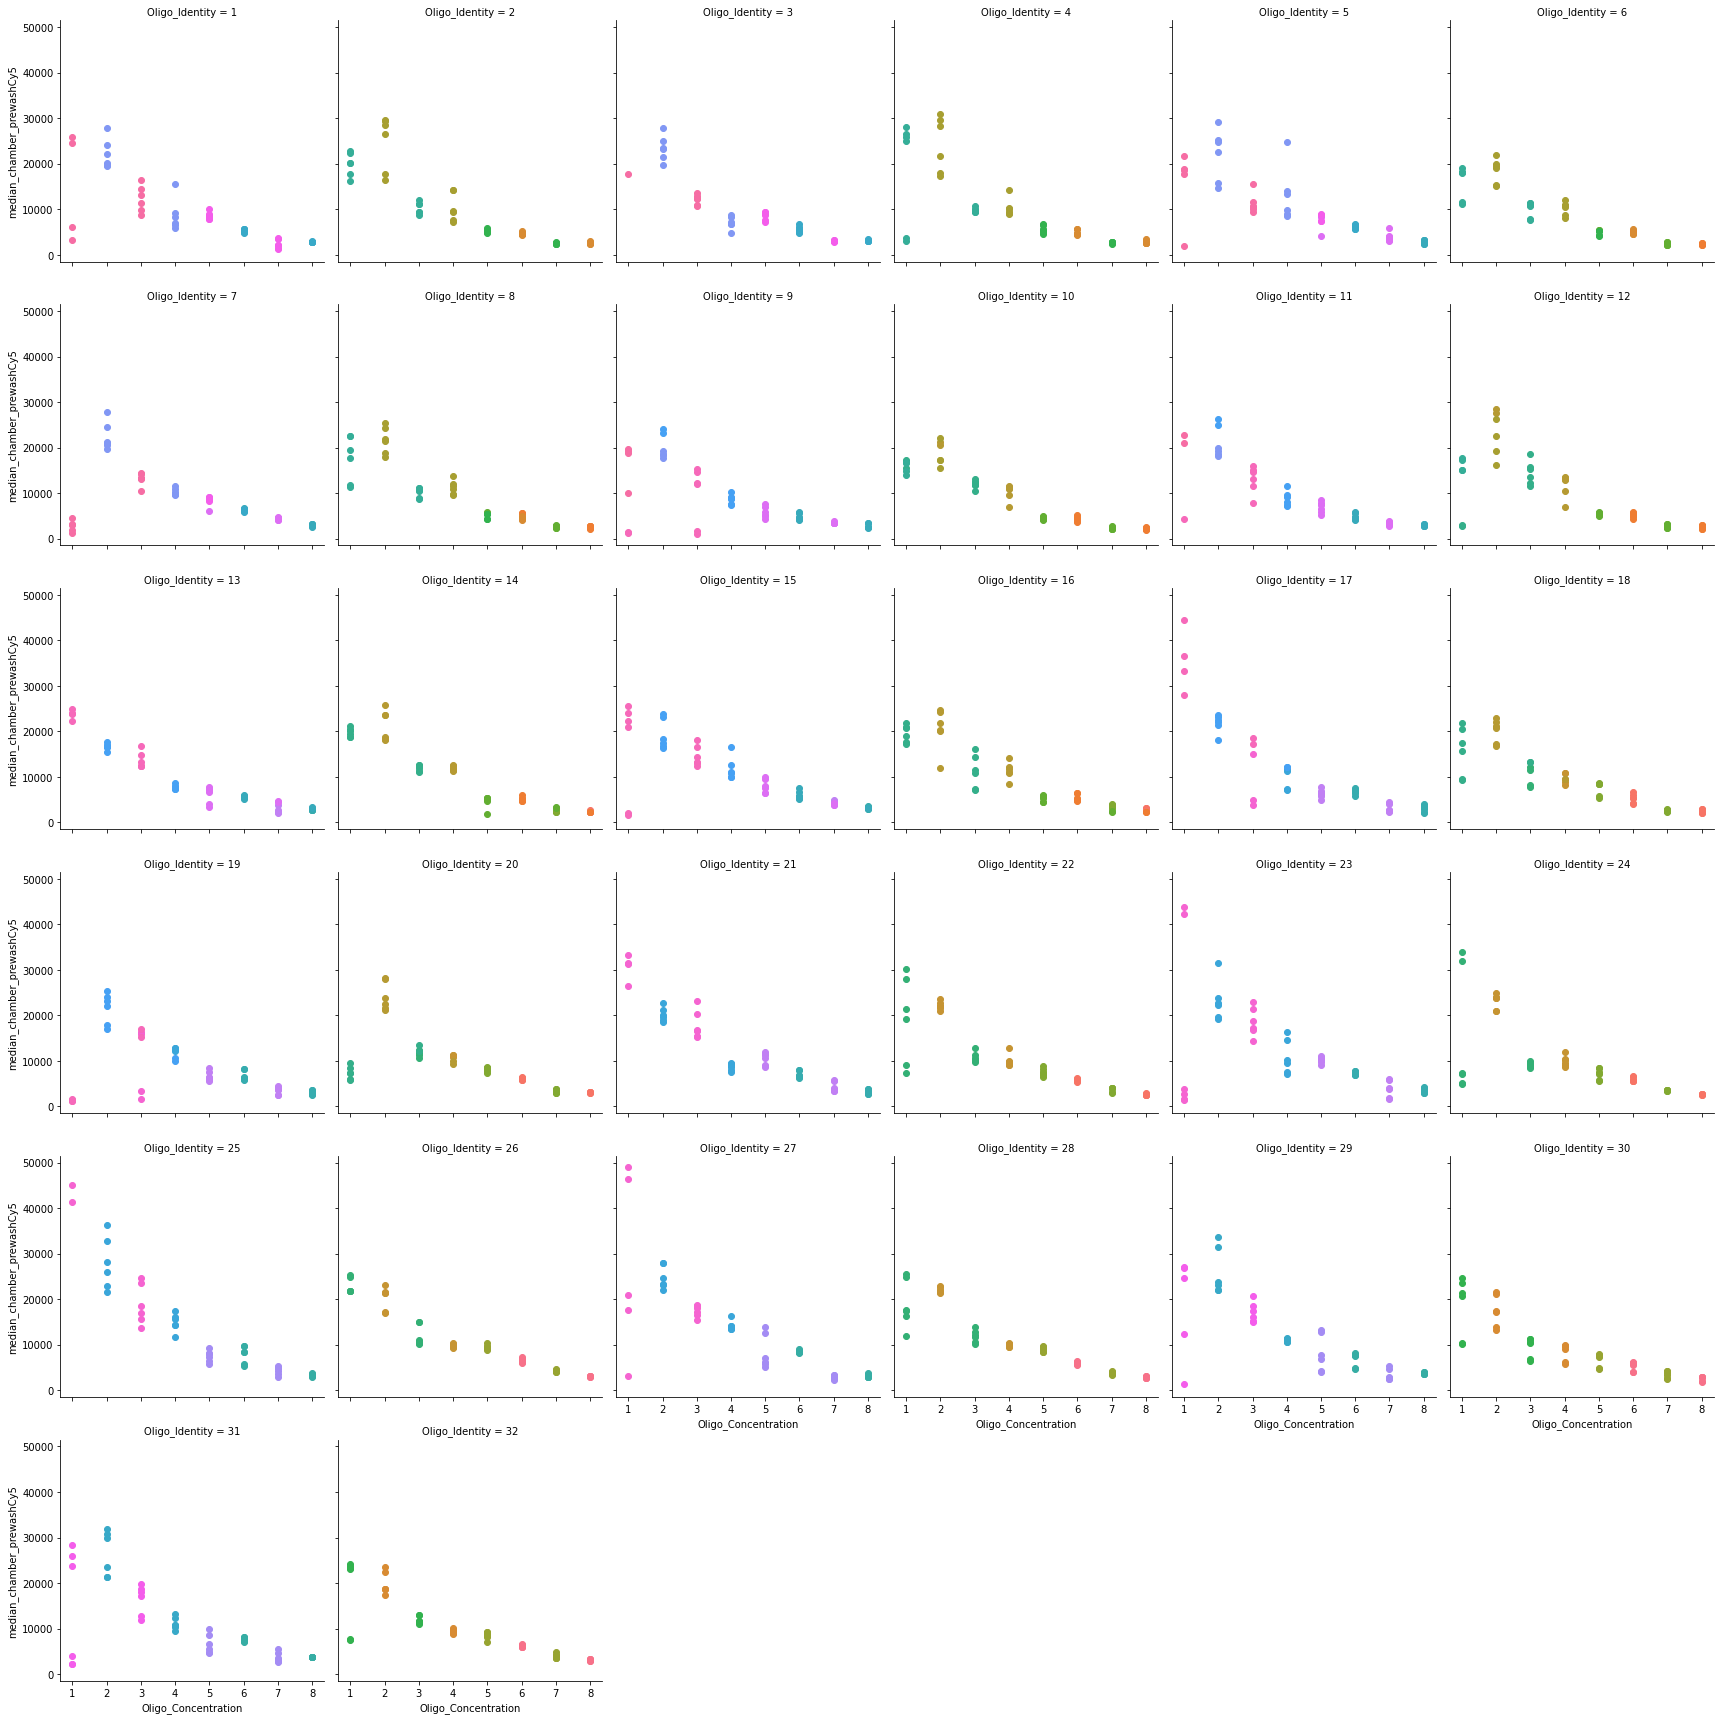

In [5]:
g = sns.FacetGrid(rawdata_df, col = "Oligo_Identity",col_wrap=6, height = 4, hue='x')
g = g.map(plt.scatter,"Oligo_Concentration", "median_chamber_prewashCy5")

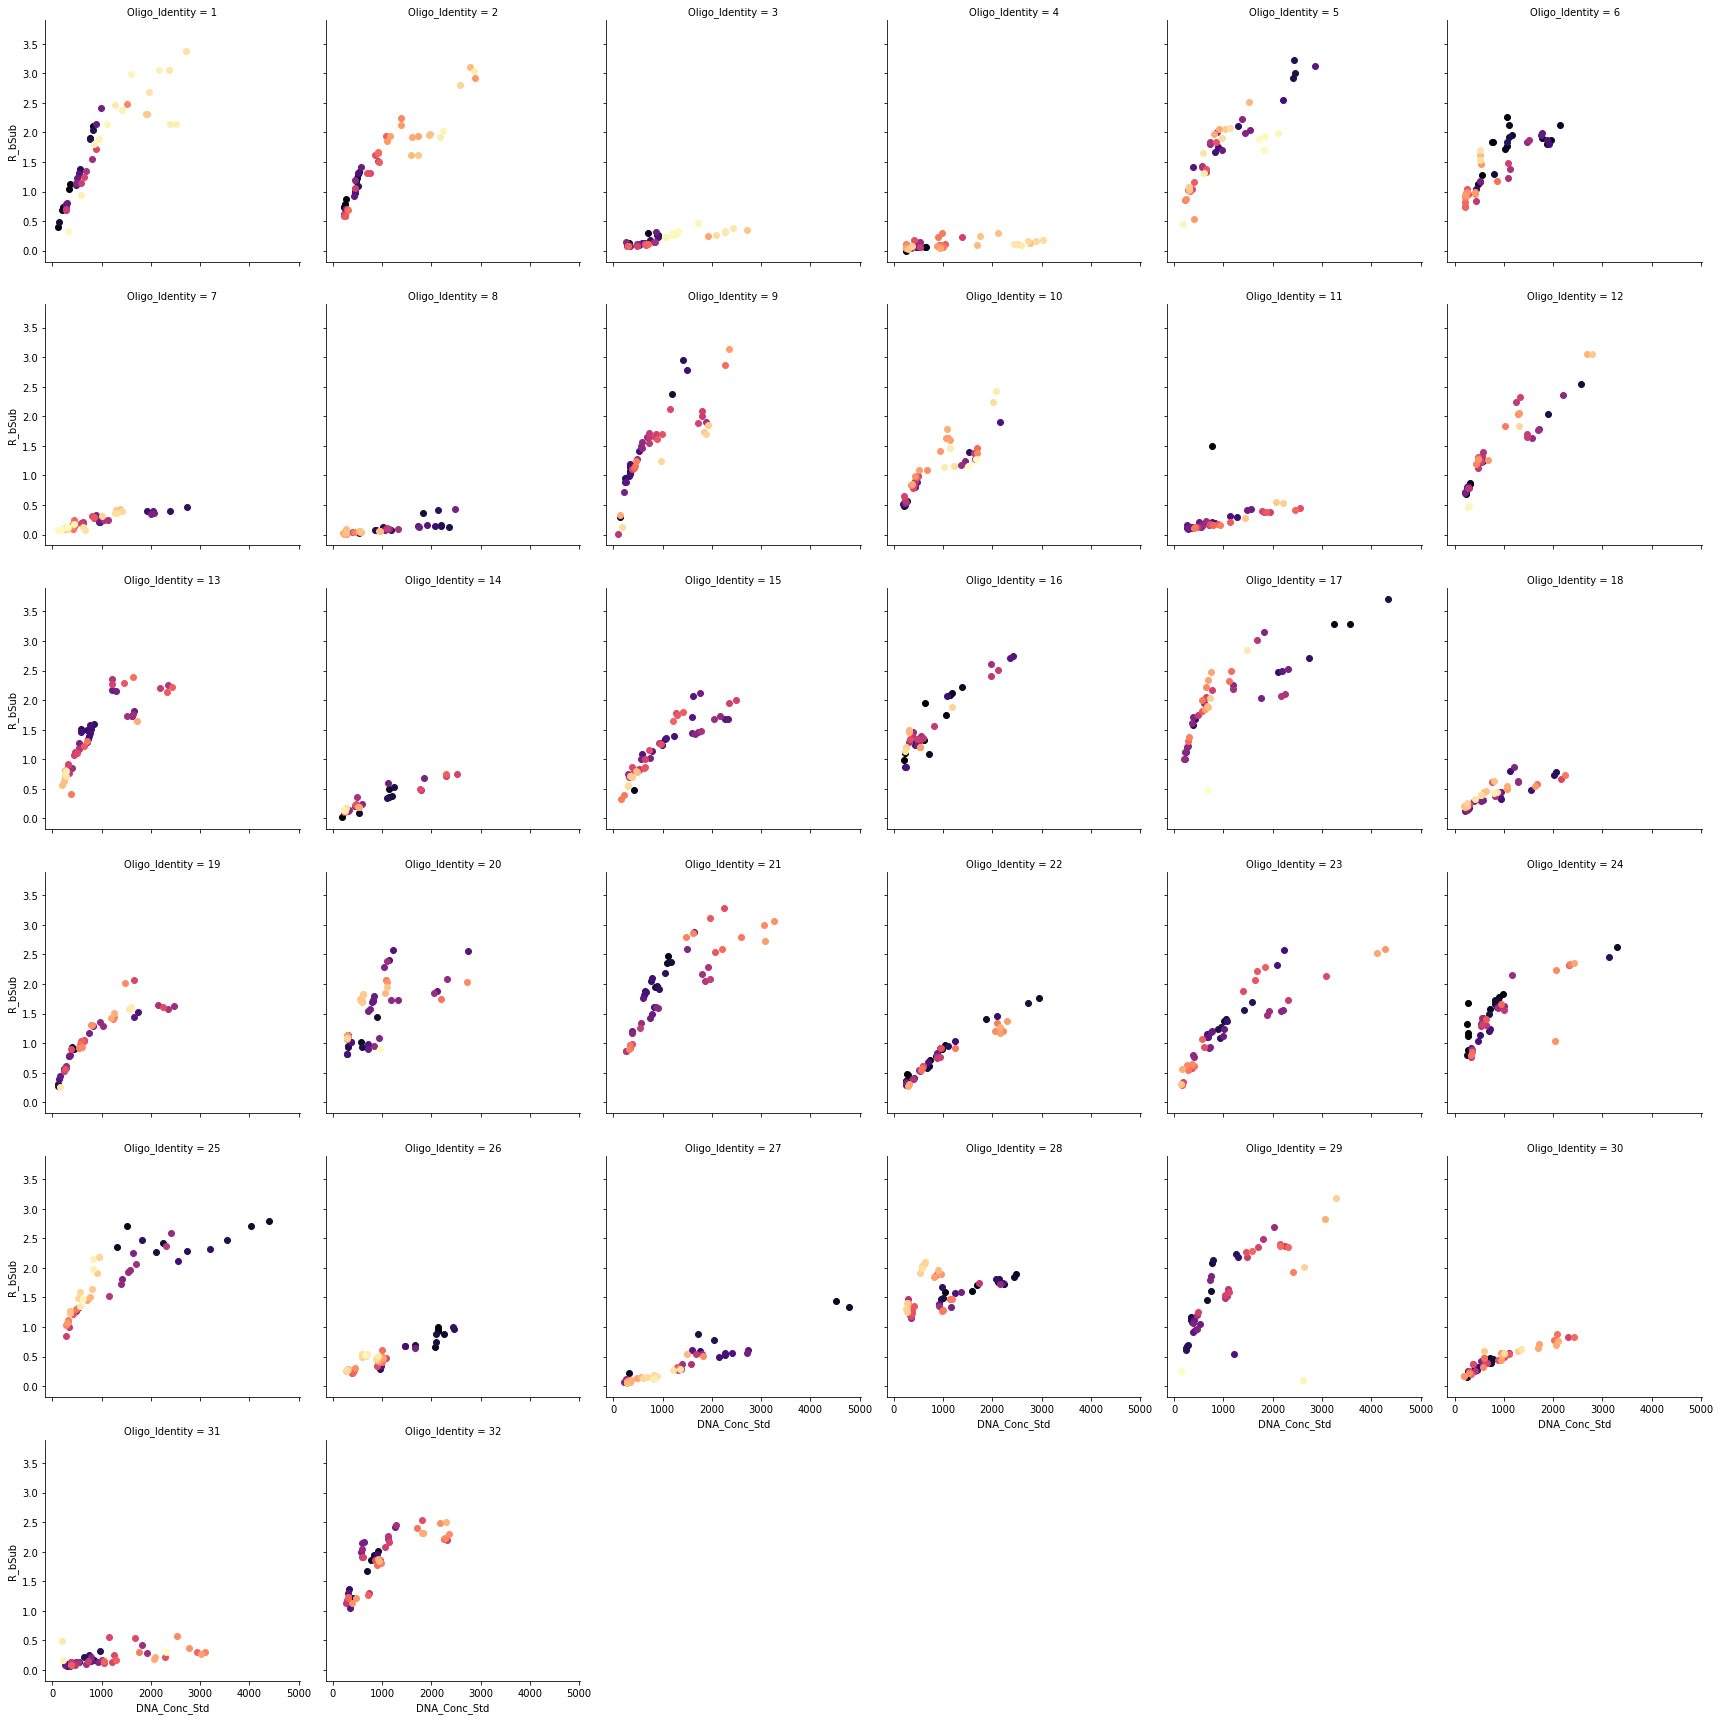

In [6]:
# rawdata_df_columnFilter = rawdata_df[rawdata_df['x'] < 28]
rawdata_df_filter = rawdata_df[rawdata_df['R_bSub'] > 0]

g = sns.FacetGrid(rawdata_df_filter, col = "Oligo_Identity",col_wrap=6, height = 4, hue='summed_button_BGsub_postwashGFP', palette='magma')
g = g.map(plt.scatter,"DNA_Conc_Std", "R_bSub")


In [7]:
# Filter data
rawdata_df_filter = rawdata_df[rawdata_df['R_bSub'] > 0]

bad_columns = [28]
bad_rows = [55,56]
rawdata_df_filter = rawdata_df_filter[~rawdata_df_filter['x'].isin(bad_columns)]

rawdata_df_filter = rawdata_df_filter[rawdata_df_filter['summed_button_BGsub_postwashGFP'] < 2.2e6]
rawdata_df_filter = rawdata_df_filter[rawdata_df_filter['summed_button_BGsub_postwashGFP'] > 1e6]

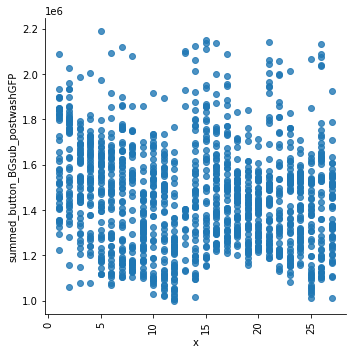

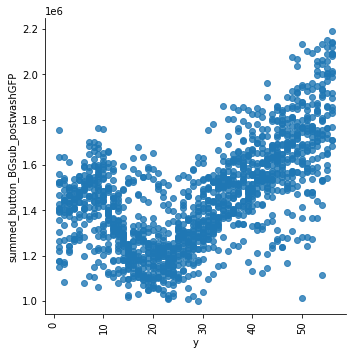

In [8]:
g = sns.lmplot(x='x',y='summed_button_BGsub_postwashGFP',data=rawdata_df_filter,fit_reg=False)
plt.xticks(rotation=90)

g = sns.lmplot(x='y',y='summed_button_BGsub_postwashGFP',data=rawdata_df_filter,fit_reg=False)
plt.xticks(rotation=90);

In [9]:
# CREATE DATAFRAME FOR CURVE FITTING

GFIT_Input = pd.DataFrame()

GFIT_Input['Onum'] = rawdata_df_filter['Oligo_Identity']
GFIT_Input['R'] = rawdata_df_filter['R_bSub']
GFIT_Input['Ch'] = rawdata_df_filter['DNA_Conc_Std']
GFIT_Input = GFIT_Input.dropna().reset_index(drop=True)

GFIT_Input.to_csv('sample_GFIT_input.csv', index = False);

In [10]:
# SET UP FIT PARAMETERS

n_sample = int(len(GFIT_Input)/2)
n_total = len(GFIT_Input)
n_iters = 1000

oligo_list = list(set(rawdata_df_filter['Oligo_Identity']))
oligo_list = [int(i) for i in oligo_list]
num_oligos = len(oligo_list)

Kd_fits = np.zeros((n_iters, len(oligo_list)))
rmax_fits = np.zeros(n_iters)

fit_params = Parameters()

Rmax_guess = np.max(GFIT_Input['R'])

for i in rawdata_df_filter['Oligo_Identity'].unique():
    fit_params.add( 'Kd_%s' % i, value=1e3, min=1,  max=1e6)

fit_params.add('ymax', value=Rmax_guess, min=0.1,  max=10)

In [11]:
# PERFORM GLOBAL FIT

for i in tqdm(range(n_iters)):
    rand = np.random.choice(n_total, n_sample, replace=False)
    subset_df = GFIT_Input.loc[rand]
    
    max_len = np.max(subset_df['Onum'].value_counts())
    data_ratios = np.zeros((num_oligos, max_len))
    data_chambers = np.zeros((num_oligos, max_len))
    
    for j in oligo_list:
        ratios = list(subset_df[subset_df['Onum']==j]['R'])
        data_ratios[int(j)-1,:len(ratios)] = ratios
        chambers = list(subset_df[subset_df['Onum']==j]['Ch'])
        data_chambers[int(j)-1,:len(chambers)] = chambers

    result_global = minimize(objective, fit_params, args=(oligo_list, data_ratios, data_chambers))  

    Kd_fits[i,:] = [result_global.params['Kd_%s' % k].value for k in oligo_list]
    rmax_fits[i] = result_global.params['ymax'].value

100%|███████████████████████████████████████| 1000/1000 [01:26<00:00, 11.62it/s]


In [12]:
# CREATE DATAFRAME WITH CURVE FITS AND SAVE TO FILE

Kd_means = np.mean(Kd_fits, axis=0)
Kd_sdevs = np.std(Kd_fits, axis=0)

rmax = np.mean(rmax_fits)

summary_stats_df = pd.DataFrame(np.vstack([oligo_list, Kd_means, Kd_sdevs]).T, columns=['Oligo_Identity','Kd_mean','Kd_sdev'])
summary_stats_df['Oligo_Identity']=summary_stats_df['Oligo_Identity'].astype('str').apply(lambda x: int(x[:-2]))

summary_stats_df = summary_stats_df.merge(oligonames)
summary_stats_df.to_csv('sample_GFIT_output.csv', index = False);

In [13]:
annotated_df = rawdata_df_filter.merge(summary_stats_df, on='Oligo_Identity')

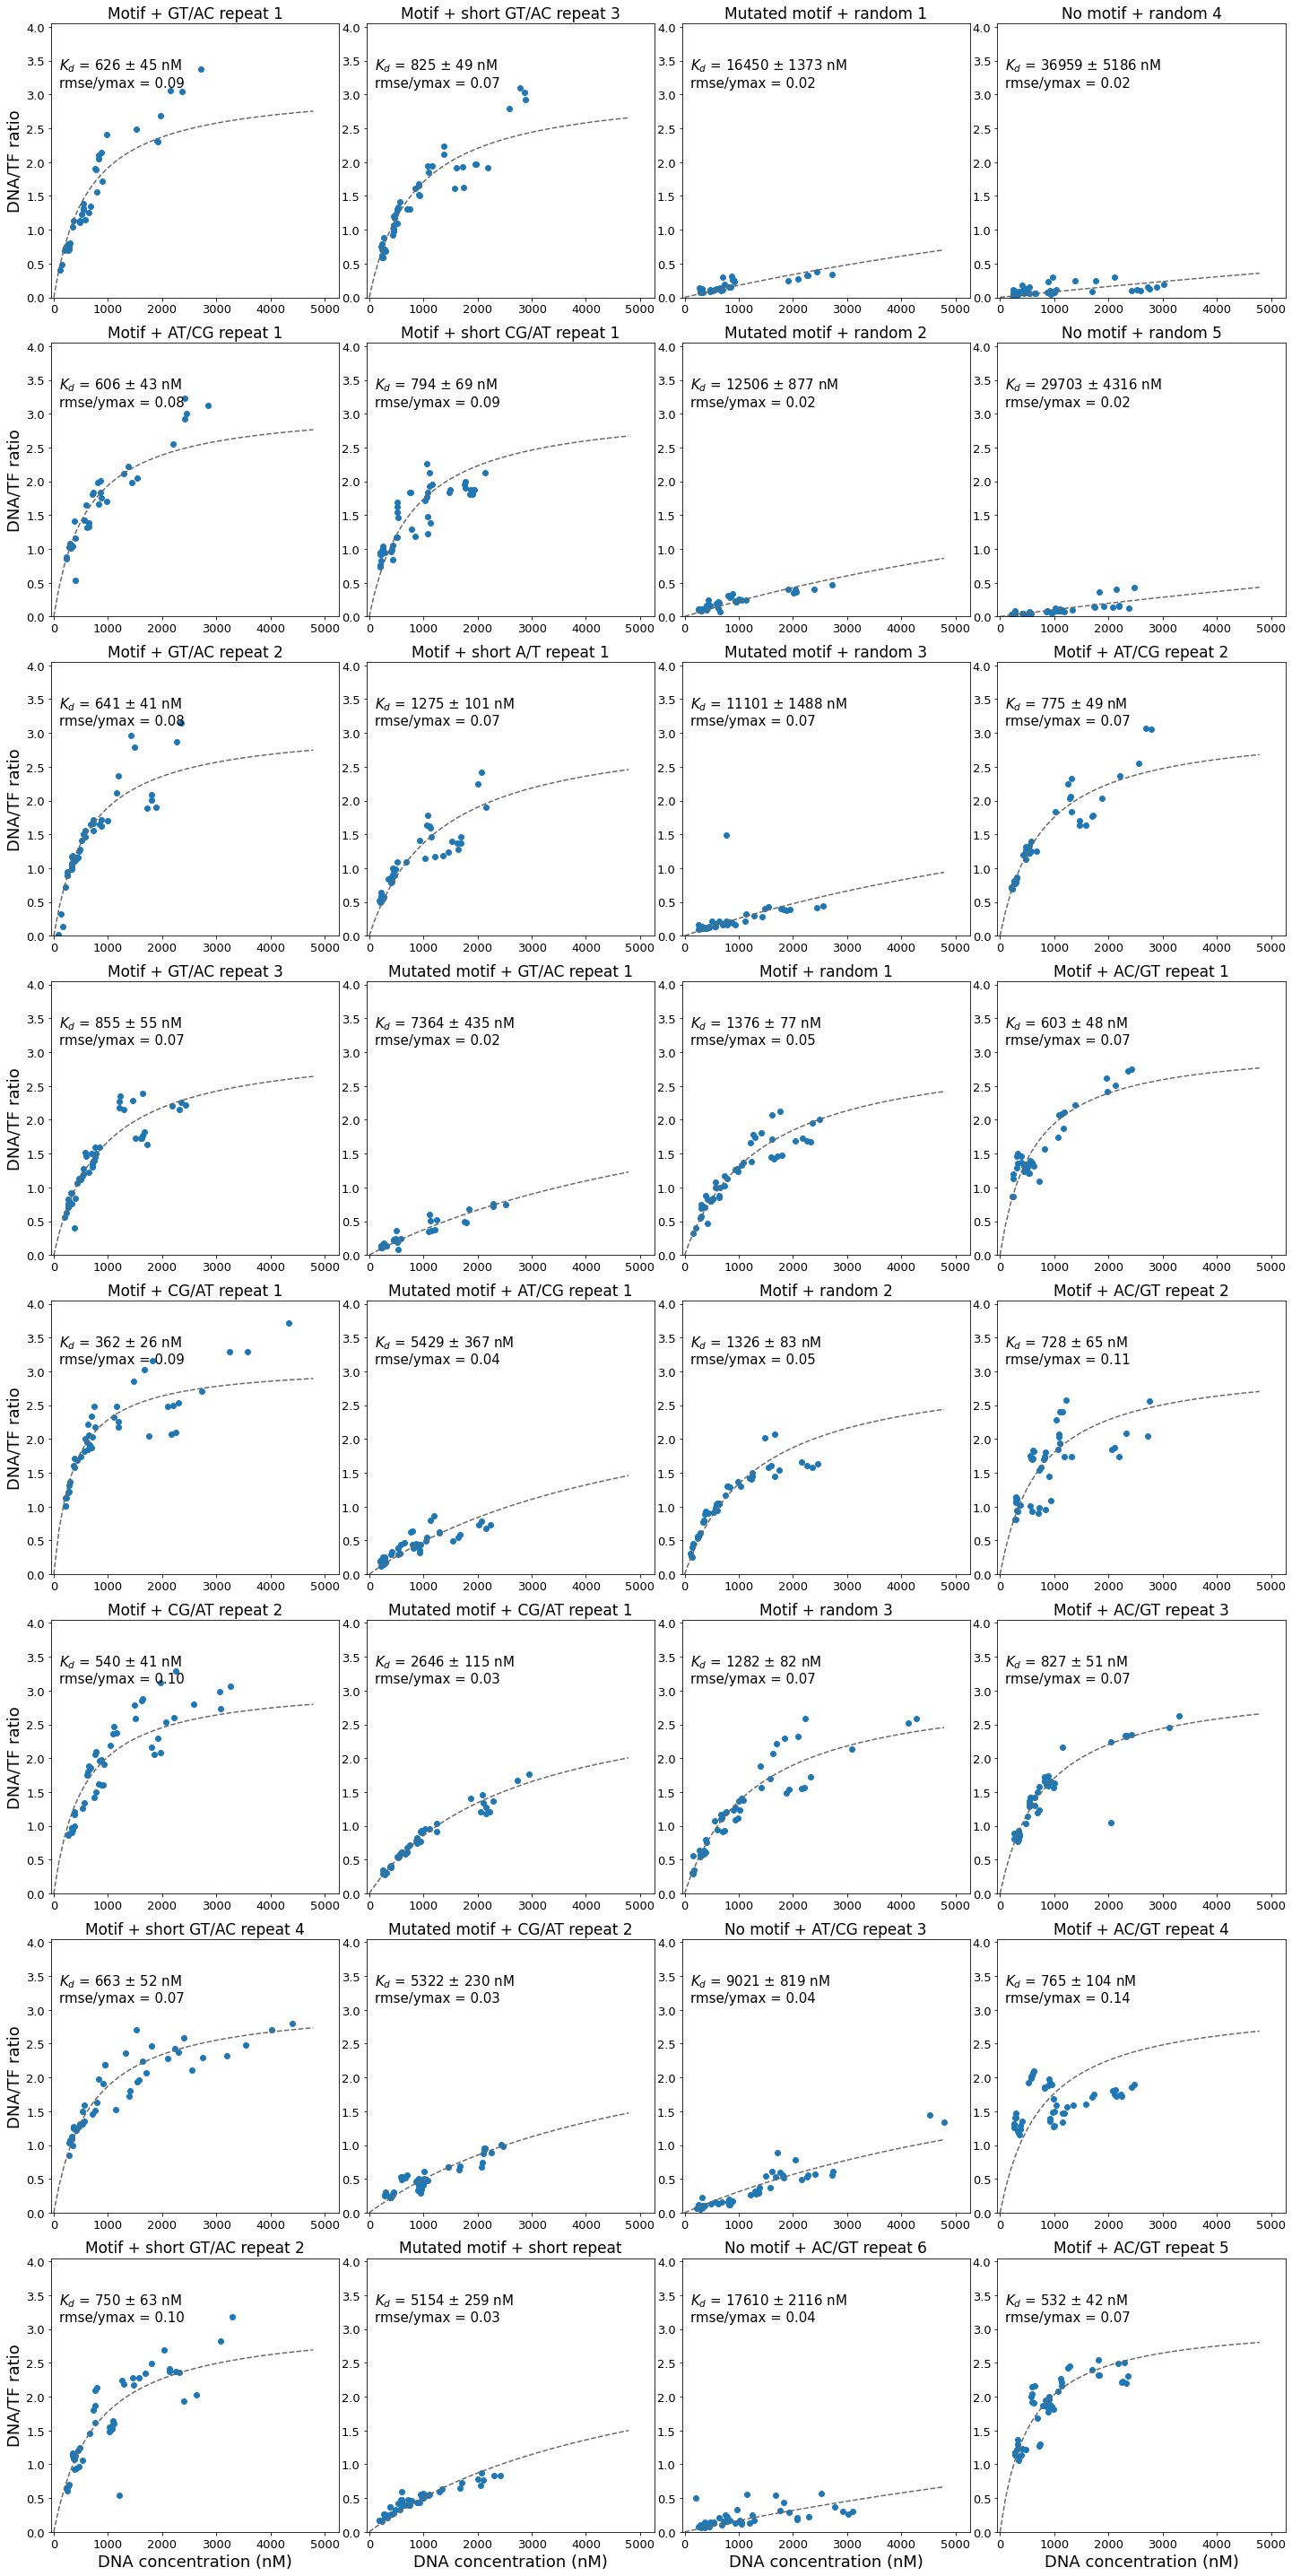

In [15]:
fig = plt.figure(figsize=(20,40))
nrow = 8
ncol = 4

DNA_max = annotated_df['DNA_Conc_Std'].max()
x = np.linspace(0,DNA_max)

for i in range(num_oligos):
    ax = fig.add_subplot(nrow,ncol,i+1)
    df_to_plot = annotated_df[annotated_df['Oligo_Identity'] == i+1]
    ax.scatter(df_to_plot['DNA_Conc_Std'], df_to_plot['R_bSub']);
    ax.set_xlim(-50,DNA_max*1.1)
    ax.set_ylim((0,rmax*1.3))
    ax.tick_params(labelsize=13)
    if i % ncol == 0:
        ax.set_ylabel('DNA/TF ratio', fontsize=18)
    if num_oligos - i - 1 < ncol: 
        ax.set_xlabel('DNA concentration (nM)', fontsize=18)
    ax.plot(x,isotherm(x,rmax,list(df_to_plot['Kd_mean'])[0]),c='dimgray',ls='--')
    diff = df_to_plot['R_bSub'] - isotherm(df_to_plot['DNA_Conc_Std'],rmax,list(df_to_plot['Kd_mean'])[0])
    rmse_rmax = np.sqrt(np.mean(diff**2))/rmax
    ax.text(100, rmax, "$K_d$ = %.f $\pm$ %.f nM\nrmse/ymax = %.2f" % (list(df_to_plot['Kd_mean'])[0], list(df_to_plot['Kd_sdev'])[0], rmse_rmax), fontsize=15)
    ax.set_title(list(df_to_plot['New_title'])[0], fontsize=17)

fig.tight_layout()

fig.savefig('sample_bindingcurves.pdf')

In [24]:
rmax

3.1092997367185284